# Fashion MNIST CNN Model

In [1]:
# references: https://www.digitalocean.com/community/tutorials/writing-cnns-from-scratch-in-pytorch

# load libraries
import torch
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
from torchvision import datasets, transforms

# define variables for the model
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 20

# determine whether to use GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data Preprocessing

In [2]:
# Normalize to [0, 1]
all_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.0,), (1.0,))
])

# Load the training dataset
full_train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=all_transforms)

# Load the testing dataset
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=all_transforms)

# Split into training and validation sets
validation_size = 10000
train_size = len(full_train_dataset) - validation_size
train_dataset, validation_dataset = random_split(full_train_dataset, [train_size, validation_size])

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100.0%
100.0%
100.0%
100.0%


### Explore the Dataset

In [3]:
# Print basic information
print("Training set size:", len(train_dataset))
print("Validation set size:", len(validation_dataset))
print("Test set size:", len(test_dataset))

print("Image shape:", train_dataset[0][0].shape)
print("Number of classes:", len(full_train_dataset.classes))

#checking class balance.
train_labels = [label for _, label in train_dataset]
validation_labels = [label for _, label in validation_dataset]
test_labels = [label for _, label in test_dataset]

print("training label distribution:", torch.bincount(torch.tensor(train_labels)))
print("validation label distribution:", torch.bincount(torch.tensor(validation_labels)))
print("testing label distribution:", torch.bincount(torch.tensor(test_labels)))

Training set size: 50000
Validation set size: 10000
Test set size: 10000
Image shape: torch.Size([1, 28, 28])
Number of classes: 10
training label distribution: tensor([4962, 4986, 5024, 4968, 4946, 5050, 5038, 4999, 5028, 4999])
validation label distribution: tensor([1038, 1014,  976, 1032, 1054,  950,  962, 1001,  972, 1001])
testing label distribution: tensor([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])


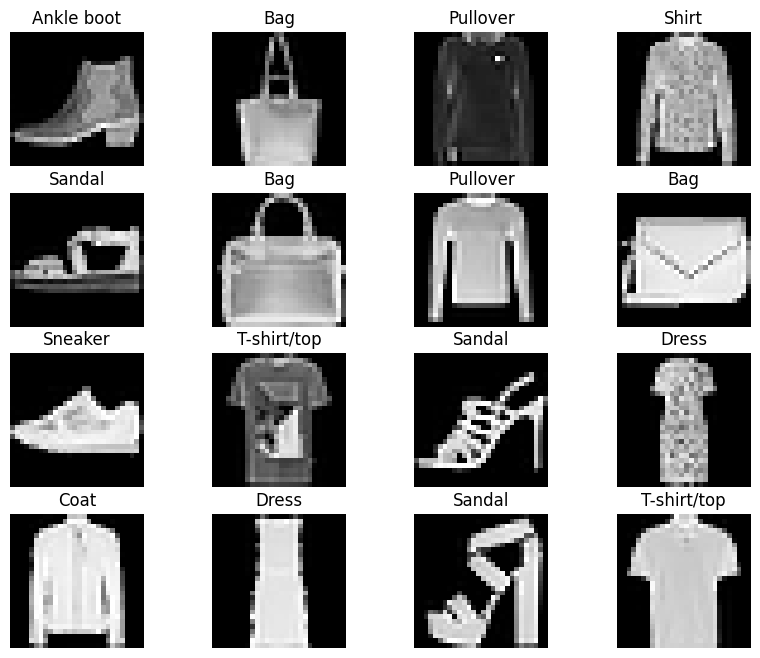

In [4]:
import matplotlib.pyplot as plt

# Get a batch of images from the training loader
view_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
images, labels = next(iter(view_loader))

# Display images
plt.figure(figsize=(10, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(full_train_dataset.classes[labels[i]])
    plt.axis('off')
plt.show()

## Building Model

In [5]:
class ConvNet(nn.Module):
    # define layers and order in CNN
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 7 * 7, 128) # 64 channels, 7x7 feature map
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    # pass data across layers
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.pool1(out)

        out = self.conv3(out)
        out = self.conv4(out)
        out = self.pool2(out)

        # reshape output to match input of fully connected layer
        out = out.reshape(out.size(0), -1)

        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

## Setting Hyperparameters

In [6]:
model = ConvNet(num_classes)

# set loss function
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

total_step = len(train_loader)

## Training Model

In [10]:
loss_values = []  # List to store loss values

for epoch in range(num_epochs):
    running_loss = 0.0  # Accumulate loss for the epoch

    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Compute average loss for the epoch
    avg_loss = running_loss / len(train_loader)
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, avg_loss))
    loss_values.append(avg_loss)


Epoch [1/20], Loss: 0.5609
Epoch [2/20], Loss: 0.4735
Epoch [3/20], Loss: 0.4220
Epoch [4/20], Loss: 0.3938
Epoch [5/20], Loss: 0.3723
Epoch [6/20], Loss: 0.3566
Epoch [7/20], Loss: 0.3416
Epoch [8/20], Loss: 0.3324
Epoch [9/20], Loss: 0.3206
Epoch [10/20], Loss: 0.3132
Epoch [11/20], Loss: 0.3045
Epoch [12/20], Loss: 0.2971
Epoch [13/20], Loss: 0.2879
Epoch [14/20], Loss: 0.2830
Epoch [15/20], Loss: 0.2757
Epoch [16/20], Loss: 0.2713
Epoch [17/20], Loss: 0.2670
Epoch [18/20], Loss: 0.2603
Epoch [19/20], Loss: 0.2565
Epoch [20/20], Loss: 0.2511


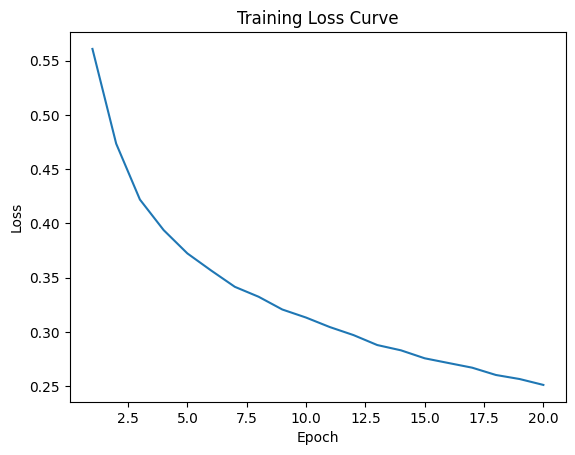

In [11]:
# plot the loss curve
plt.plot(range(1, num_epochs + 1), loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

## Evaluating Model

In [12]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the {} train images: {} %'.format(50000, 100 * correct / total))

Accuracy of the network on the 50000 train images: 91.694 %


## Experimentation & Improvements